In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [3]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [4]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [135]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_numbers = [1, 2, 5, 10, 20, 40, 80, 160]
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rates = [1000.0, 3000.0, 10000.0, 30000.0, 100000.0, 300000.0]
#ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rate = 300.0
#trna_charging_rates = [30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 3
ribosome_footprint = 15

date = "march-27-2024"

In [6]:
!mkdir ../output/march-27-2024
!mkdir ../yaml/march-27-2024

mkdir: cannot create directory ‘../output/march-27-2024’: File exists
mkdir: cannot create directory ‘../yaml/march-27-2024’: File exists


In [7]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [11]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for ecol_rbs_rate in ecol_rbs_rates:
            for gfp_transcript_copy_number in gfp_transcript_copy_numbers:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ecol_rbs_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [136]:
ecol_rbs_rates = [1000.0, 3000.0, 10000.0, 30000.0, 100000.0, 300000.0]
gfp_transcript_copy_numbers = [1, 2, 5, 10, 20, 40, 80, 160]
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
df_master = None

for binding_rate in ecol_rbs_rates:
    df_bind = None
    for copy_number in gfp_transcript_copy_numbers:
        df_copy_number = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{binding_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 100, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_copy_number is not None:
                df_copy_number = df_copy_number.append(tmp, ignore_index=True)
            else:
                df_copy_number = tmp
        df_copy_number["gfp_copy"] = copy_number
        if df_bind is not None:
            df_bind = df_bind.append(df_copy_number, ignore_index=True)
        else:
            df_bind = df_copy_number
    df_bind["bind_rate"] = binding_rate
    if df_master is not None:
        df_master = df_master.append(df_bind, ignore_index=True)
    else:
        df_master = df_bind

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3676531/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [137]:
#df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_copy', 'codon', 'bind_rate'], columns='species', values='protein').reset_index()

#df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
#df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
#df["free ribosome"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'bind_rate'])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

In [127]:
df

species,gfp_copy,codon,bind_rate,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_max,cellularProtein_norm
0,1,0.1,1000.0,738.000000,12.000000,1.000000,1731.666667,18.333333,1.000000,100.000000,1057.333333,497.333333,1057.333333,1.000000
1,1,0.1,3000.0,713.666667,36.333333,1.000000,1700.000000,50.000000,1.000000,100.000000,2986.000000,491.000000,3040.666667,0.982021
2,1,0.1,10000.0,624.333333,125.666667,1.500000,1570.333333,179.666667,1.000000,98.666667,9653.333333,467.333333,9653.333333,1.000000
3,1,0.1,30000.0,434.000000,316.000000,3.500000,1292.000000,458.000000,1.000000,97.666667,23802.666667,394.333333,23802.666667,1.000000
4,1,0.1,100000.0,233.333333,516.666667,3.666667,964.333333,785.666667,1.000000,98.666667,38721.666667,188.000000,38727.666667,0.999845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,160,0.9,3000.0,686.666667,63.333333,7680.333333,1578.000000,172.000000,160.000000,99.666667,2963.666667,481.000000,3046.000000,0.972970
236,160,0.9,10000.0,617.000000,133.000000,23457.000000,1361.666667,388.333333,160.000000,100.000000,9102.666667,448.000000,9656.666667,0.942630
237,160,0.9,30000.0,426.666667,323.333333,51570.333333,911.000000,839.000000,159.000000,98.666667,19964.666667,331.666667,23755.666667,0.840417
238,160,0.9,100000.0,308.000000,442.000000,71304.666667,538.000000,1212.000000,157.333333,98.666667,27687.000000,141.666667,38736.666667,0.714749


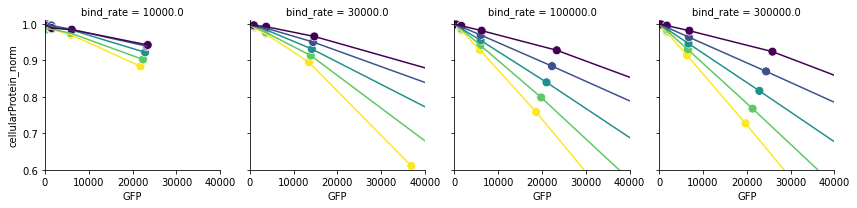

In [138]:
df_plot = df[(df.bind_rate > 3000.0)]
g = sns.FacetGrid(df_plot, col="bind_rate")
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")
g.set(xlim=(0, 40000))
g.set(ylim=(0.6, 1.01))

In [139]:
df.to_csv("regression_med_rib_binding.csv")

In [142]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_numbers = [1, 2, 5, 10, 20, 40, 80, 160]
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rates = [1000.0, 3000.0, 10000.0, 30000.0, 100000.0, 300000.0]
#ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rate = 1000.0
#trna_charging_rates = [30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 3
ribosome_footprint = 15

date = "march-29-2024"

In [141]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_numbers = [1, 2, 5, 10, 20, 40, 80, 160]
ribosome_copy_number = 500
total_trna = 2500
#ecol_rbs_rates = [1000.0, 3000.0, 10000.0, 30000.0, 100000.0]
ecol_rbs_rates = [300000.0]
#ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rate = 1000.0
#trna_charging_rates = [30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.6, 0.4) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 3
ribosome_footprint = 15

date = "march-29-b-2024"

In [114]:
!mkdir ../output/march-29-b-2024
!mkdir ../yaml/march-29-b-2024

In [115]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [116]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for ecol_rbs_rate in ecol_rbs_rates:
            for gfp_transcript_copy_number in gfp_transcript_copy_numbers:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {ecol_rbs_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [143]:
df_master = None
for binding_rate in ecol_rbs_rates:
    df_bind = None
    for copy_number in gfp_transcript_copy_numbers:
        df_copy_number = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.6_0.4_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{binding_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 100, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_copy_number is not None:
                df_copy_number = df_copy_number.append(tmp, ignore_index=True)
            else:
                df_copy_number = tmp
        df_copy_number["gfp_copy"] = copy_number
        if df_bind is not None:
            df_bind = df_bind.append(df_copy_number, ignore_index=True)
        else:
            df_bind = df_copy_number
    df_bind["bind_rate"] = binding_rate
    if df_master is not None:
        df_master = df_master.append(df_bind, ignore_index=True)
    else:
        df_master = df_bind

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_3676531/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [120]:
df_master[(df_master.bind_rate == 300000.0)]

,time,species,protein,ribo_density,delta,codon,gfp_copy,bind_rate
3609,100.0,ATA_charged,427.333333,0.000000,3.666667,0.9,1,300000.0
3610,100.0,ATA_uncharged,322.666667,0.000000,-3.666667,0.9,1,300000.0
3611,100.0,GFP,7.000000,0.000000,2.333333,0.9,1,300000.0
3612,100.0,TTT_charged,1271.333333,0.000000,0.333333,0.9,1,300000.0
3613,100.0,TTT_uncharged,478.666667,0.000000,-0.333333,0.9,1,300000.0
...,...,...,...,...,...,...,...,...
4315,100.0,TTT_uncharged,270.000000,0.000000,7.333333,0.1,160,300000.0
4316,100.0,__GFP_rbs,154.333333,0.000000,-2.666667,0.1,160,300000.0
4317,100.0,__cellularProtein_rbs,99.000000,0.000000,1.666667,0.1,160,300000.0
4318,100.0,free ribosome,59.000000,0.000000,-9.000000,0.1,160,300000.0


In [144]:
df = df_master.pivot_table(index=['gfp_copy', 'codon', 'bind_rate'], columns='species', values='protein').reset_index()

#df["TTT_charged"] = df["TTT_charged"] / (total_trna*0.7)
#df["ATA_charged"] = df["ATA_charged"] / (total_trna*0.3)
#df["free ribosome"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'bind_rate'])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

In [145]:
df

species,gfp_copy,codon,bind_rate,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,cellularProtein_max,cellularProtein_norm
0,1,0.1,1000.0,746.000000,4.000000,1.000000,1744.666667,5.333333,1.000000,100.000000,1043.333333,497.000000,1048.666667,0.994914
1,1,0.1,3000.0,739.333333,10.666667,1.000000,1735.666667,14.333333,1.000000,100.000000,2997.000000,491.333333,3092.666667,0.969067
2,1,0.1,10000.0,713.000000,37.000000,2.500000,1699.666667,50.333333,1.000000,99.333333,9665.333333,471.666667,9728.333333,0.993524
3,1,0.1,30000.0,633.333333,116.666667,3.500000,1575.000000,175.000000,1.000000,99.333333,25453.666667,409.333333,25453.666667,1.000000
4,1,0.1,100000.0,510.666667,239.333333,3.666667,1404.000000,346.000000,1.000000,97.333333,56171.333333,274.000000,56171.333333,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,160,0.9,3000.0,732.333333,17.666667,7765.333333,1703.000000,47.000000,160.000000,99.666667,3000.000000,483.000000,3033.666667,0.988902
236,160,0.9,10000.0,707.333333,42.666667,23890.666667,1607.000000,143.000000,159.666667,99.666667,9296.333333,447.666667,9742.666667,0.954188
237,160,0.9,30000.0,642.000000,108.000000,59062.000000,1454.666667,295.333333,159.333333,99.000000,22928.666667,378.000000,25454.666667,0.900765
238,160,0.9,100000.0,569.000000,181.000000,111631.000000,1182.333333,567.666667,158.666667,100.000000,43528.000000,224.000000,56153.333333,0.775163


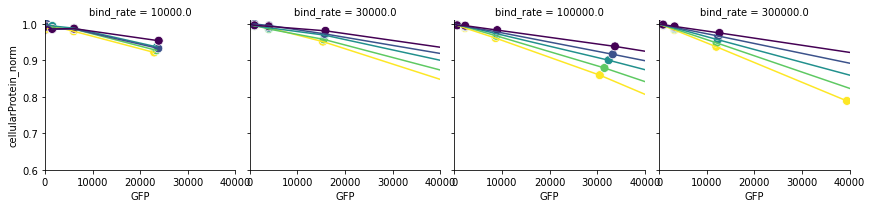

In [146]:
df_plot = df[(df.bind_rate > 3000.0)]
g = sns.FacetGrid(df_plot, col="bind_rate")
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")
g.set(xlim=(0, 40000))
g.set(ylim=(0.6, 1.01))

In [147]:
df.to_csv("regression_med_rib_binding_v2.csv")